In [392]:
from scripts.sql_connect import sql_connection, load_df
import sqlalchemy as sa
import pandas as pd
from math import sin, cos, sqrt, atan2, radians

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

### Data Load

In [25]:
connection = sql_connection()

In [27]:
table_name = "rpsale_resbldg_w_location"
schema = "public"

resbldg = load_df(table_name, schema)

### Explore

In [146]:
import matplotlib.pyplot as plt

In [61]:
resbldg = resbldg.fillna('')

In [673]:
data = resbldg[[
    'DocumentDate', 'Condition', 'YrRenovated', 'YrBuilt', 'saleprice', 'neighborho', 
    'SqFtTotLiving', 'SqFtTotBasement', 'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 
    'BldgGrade', 'SaleWarningCt', 
    'ViewUtilization', 'Bedrooms', 'PropertyClass', 'SaleReason', 'SellerName', 
    'Stories', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount',
    'lat', 'lon']][    
# filters
    (resbldg['DocumentDate'] >= '2010-01-01') &
    (resbldg['ctyname'].apply(lambda x: x.strip()) == 'SEATTLE') &
    (resbldg['PrincipalUse'].apply(lambda x: x.strip()) == 'RESIDENTIAL') &
    (resbldg['PropertyClass'].apply(lambda x: x.strip() in ['Res-Improved property', 'Res-Land only'])) &
    (resbldg['saleprice'] > 0)]

In [674]:
# Use parent neighborhoods
hood_map = pd.read_csv('hood_map_full.csv')
data['hood'] = data['neighborho'].apply(lambda x: hood_map[hood_map['subhood'] == x]['hood'].values[0])

In [675]:
data.shape

(38242, 26)

In [679]:
data.drop_duplicates(subset = ['DocumentDate', 'saleprice', 'hood', 'lat', 'lon'], inplace=True)
data.shape

(27660, 26)

In [689]:
# Clean up some columns
data['YrSinceSale'] = data['DocumentDate'].apply(lambda x: 2019 - x.year)
data['SaleMonth'] = data['DocumentDate'].apply(lambda x: x.month)
data['Age'] = data['YrBuilt'].apply(lambda x: 2019 - int(x))
data['Renovated'] = data['YrRenovated'] > 0
data['DaylightBasement'] = data['DaylightBasement'].isin(['Y', 'y'])
data['Porch'] = data['SqFtOpenPorch'] + data['SqFtEnclosedPorch'] > 0
data['Deck'] = data['SqFtDeck'] > 0
data['Condition'] = data['Condition'].apply(lambda x: x.strip())
data['BldgGrade'] = data['BldgGrade'].apply(lambda x: x.strip()[3:])
data['PropertyClass'] = data['PropertyClass'].apply(lambda x: x.strip())
data['ViewUtilization'] = data['ViewUtilization'].isin(['Y', 'y'])
data['SaleReason'] = data['SaleReason'].apply(lambda x: x.strip())
data['Baths'] = data['BathFullCount'] + 0.75*data['Bath3qtrCount'] + 0.5*data['BathHalfCount']

# Top three sellers
data['Seller_NWTrustee'] = data['SellerName'].apply(lambda x: x.strip()) == 'NORTHWEST TRUSTEE SERVICES INC'
data['Seller_NHA'] = data['SellerName'].apply(lambda x: x.strip()) == 'SEATTLE HOUSING AUTHORITY'
data['Seller_FNB'] = data['SellerName'].apply(lambda x: x.strip()) == 'SEATTLE FIRST NATL BANK'

# Top neighborhoods
top_hoods = [h for h, v in zip(data.hood.value_counts().index, data.hood.value_counts()) if v > 1000]
for h in top_hoods:
    data[h] = data['hood'] == h

In [691]:
# Combine some categories in BldgGrade and SaleReason

data['BldgGrade'] = data['BldgGrade'].replace(
    to_replace=['Low', 'Poor'], value='Fair').replace(
    to_replace='Mansion', value='Luxury')

data['SaleReason'] = data['SaleReason'].replace(
    to_replace=['', 'None'], value='Other')

In [692]:
# Distance to city center
def seattle_dist(ll):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(122.3321)
    lon1 = radians(47.6062)
    lat2 = radians(ll[0])
    lon2 = radians(ll[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return(R * c)

In [693]:
data['DistToCenter'] = data[['lat', 'lon']].apply(seattle_dist, axis=1)

In [702]:
# CHOSEN FEATURES
X = data[[
    'YrSinceSale', #'SaleMonth', 
    'Age', 'Renovated', 
    'Condition', 'BldgGrade', 'PropertyClass', 'SaleWarningCt', 'SaleReason', 
    'SqFtTotLiving', 'SqFtTotBasement',
    'Stories', 'Bedrooms', 'Baths', 
    'DaylightBasement', 'Deck', 'Porch', 'ViewUtilization', 
    'Seller_NWTrustee', 'Seller_NHA', 'Seller_FNB',
    'DistToCenter'] + top_hoods
]

X = pd.get_dummies(X, columns = ['Condition', 'BldgGrade', 'PropertyClass', 'SaleReason', 
                                    #'SaleMonth'
                                ])

y = data['saleprice']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=91)

### Model

In [699]:
GB = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, subsample=0.5, random_state=91)

In [703]:
GB.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=91, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [704]:
GB.score(X_test, y_test)

0.6947176297173441

### Interpret!

In [540]:
explainer = shap.TreeExplainer(GB)

#Use a sample of the data
X_sample = X_train.sample(n=500, random_state=91)
shap_values = explainer.shap_values(X_sample)

shap.force_plot(explainer.expected_value, shap_values, X_sample)

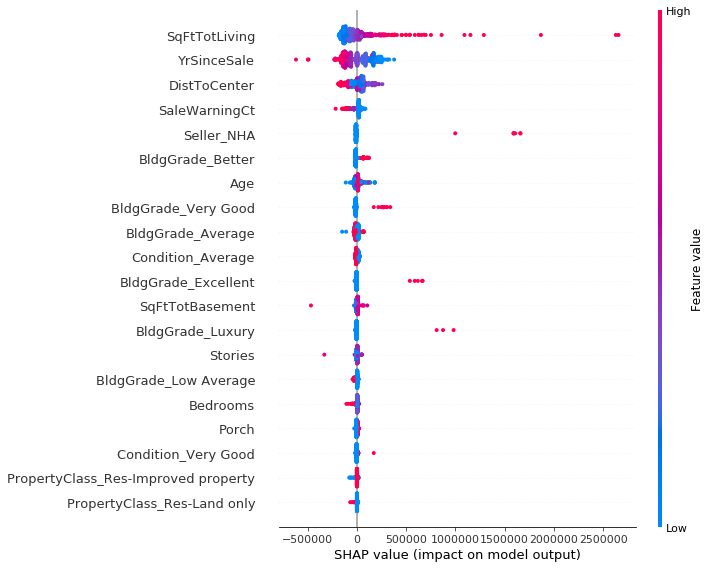

In [705]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sample)

In [542]:
#Why is Seller_NHA such a strong indicator?
y_train[X_sample[X_sample['Seller_NHA']].index]

91693     3300000
119557    3300000
188769    2610000
279324    3300000
176339    3300000
63284     3300000
168785     810000
Name: saleprice, dtype: int64

In [543]:
#Across the entire training set, rows with Seller_NHA == 1 have very specific selling prices
y_train[X_train[X_train['Seller_NHA']].index].value_counts()

3300000    40
2610000    25
810000      8
240000      2
143200      1
Name: saleprice, dtype: int64

In [549]:
shap.dependence_plot("Stories", shap_values, X_sample)

In [550]:
# Let's explore Stories too
y_train[X_sample[X_sample['Stories'] ==2.5].index]

81488     1190000
247084     975000
233307     649900
229674    4310000
227378    4700000
168785     810000
275430    1200000
Name: saleprice, dtype: int64

In [485]:
print(y_train[X_train['SqFtTotBasement'] > 3000].mean())
print(y_train[X_train['SqFtTotBasement'] <= 3000].mean())

3843076.923076923
632778.8616575974


In [552]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(X_sample['Stories'], y_train[X_sample.index], alpha=0.3)